In [1]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import json
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

import librosa
import librosa.display

from scipy.signal import butter
from scipy.signal import lfilter
from scipy.signal import freqz;
import os

In [ ]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

In [2]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='highpass', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y;

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


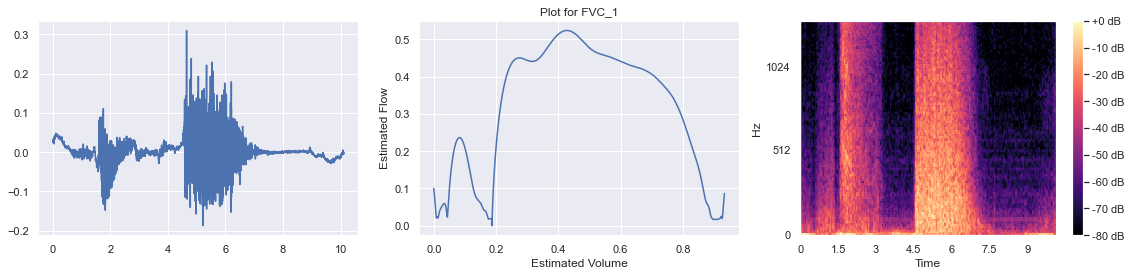

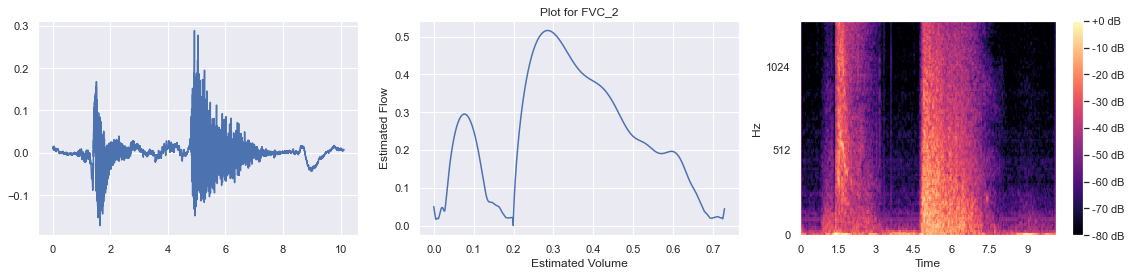

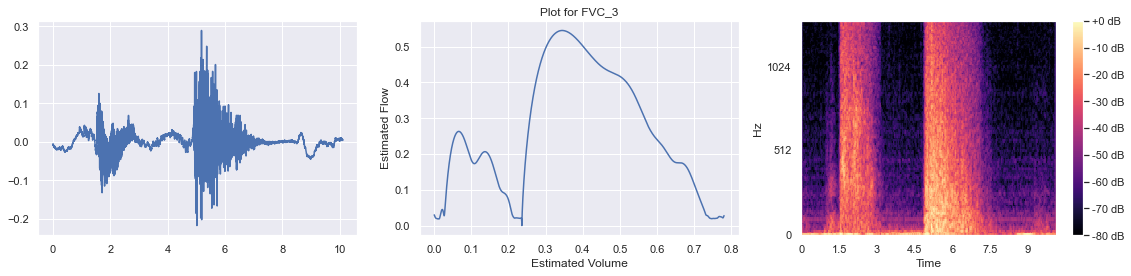

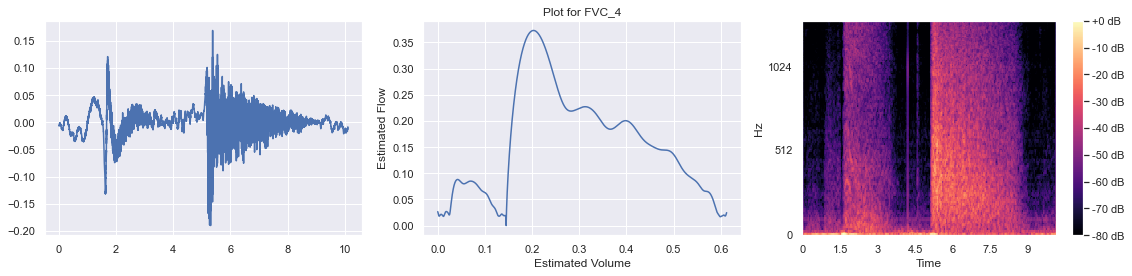

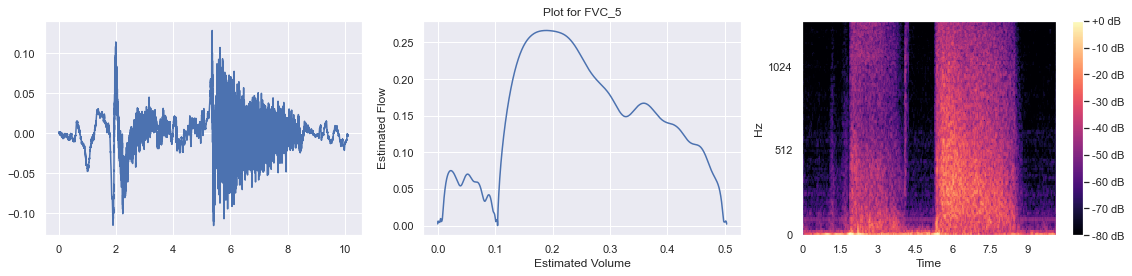

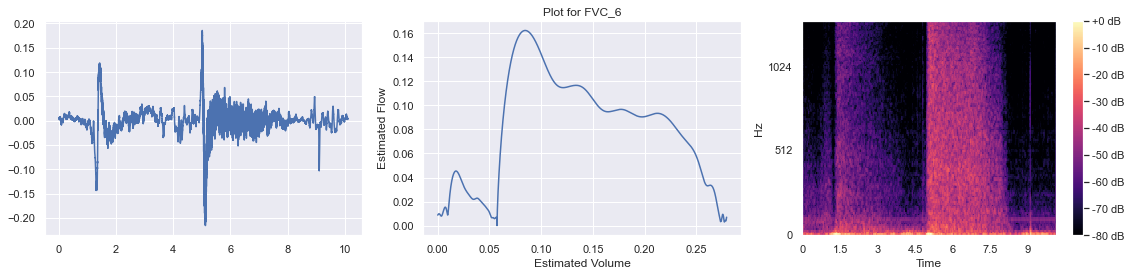

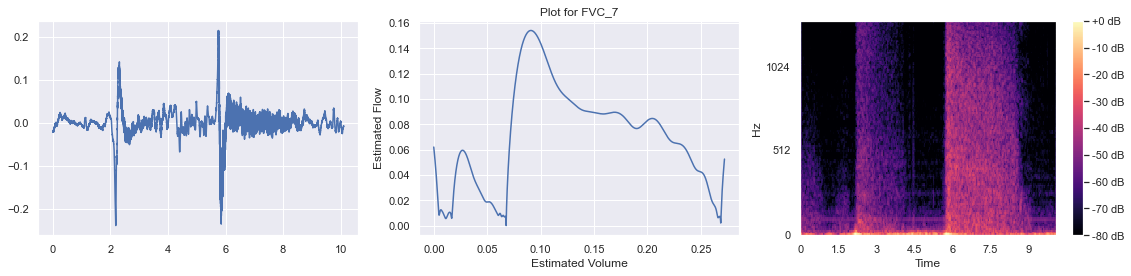

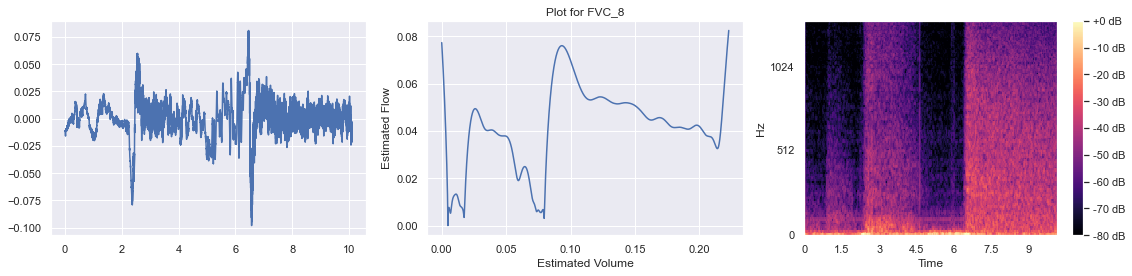

In [62]:

    
mypath="uCdata/"
(_, _, filenames) = next(os.walk(mypath))
names = [file.split('.')[0] for file in filenames]

envelope_info_list_spiromask = []

for file in filenames:
    fig,ax = plt.subplots(1,3,figsize=(16,4))
    x, fs = librosa.load(mypath+file, sr=16000)
    t = np.arange(0,len(x))/fs
    cutoff_low = 50 # desired cutoff frequency of the filter, Hz
    cutoff_high = 1500
    order = 4

    #x_filt = butter_highpass_filter(x, cutoff, fs, order)
    x_filt = butter_bandpass_filter(x,cutoff_low,cutoff_high,fs,order)
    x_filt_hilbert = signal.hilbert(x_filt)
    envelope_hat = np.abs(x_filt_hilbert)
    #filter the Hilbert envelope
    nyq_rate = fs /0.5
    width = 1.0/nyq_rate # 5 Hz filter transition width.
    ripple_db = 10.0 # stop band attenuation
    fL_hz = 10
    N, beta = signal.kaiserord(ripple_db, width)
    taps = signal.firwin(N, fL_hz/nyq_rate, window=('kaiser', beta))
    envelope_hat_filt = signal.filtfilt(taps, 1,envelope_hat)
    t = np.arange(0,len(envelope_hat_filt))/fs

    #at this point we have the 
    #scale the envelope is estimate of flow rate. We will scale this to match actual flow range
    envelope_hat_filt = np.interp(envelope_hat_filt, (envelope_hat_filt.min(), 1), (0, 8))
    rPEF = round(envelope_hat_filt.max(),2)

    estdVolume = np.cumsum(envelope_hat_filt)
    estdVolume = np.interp(estdVolume, (0, np.cumsum([1]*len(t)).max()), (0, 8))
    #FEV1 Estimate
    rFEV1 = round(estdVolume[np.where(t==1)[0][0]],2)
    #FVC Estimate
    rFVC = round(estdVolume[-1],2)

    rRatio = (rFEV1/rFVC)*100
    ax[0].plot(t,x)

    ax[1].plot(estdVolume, envelope_hat_filt)
    ax[1].set_xlabel('Estimated Volume')
    ax[1].set_ylabel('Estimated Flow')
    ax[1].set_title('Plot for {}'.format(file.split('.')[0]))

    envelope_info_list_spiromask.append(envelope_hat_filt)
    
    S = librosa.feature.melspectrogram(y=x, sr=fs, n_mels=128,fmax=cutoff_high)
    S_dB = librosa.power_to_db(S, ref=np.max)
    img = librosa.display.specshow(S_dB, x_axis='time',y_axis='mel', sr=fs,fmax=cutoff_high, ax=ax[2])
    fig.colorbar(img, ax=ax[2], format='%+2.0f dB')
    
    
    fig.tight_layout()
    
    plt.show()
    #break



In [64]:
envelope_info_list_spiromask = np.array(envelope_info_list_spiromask)
#np.save('spiromask-envelopes.npy', envelope_info_list_spiromask)

In [82]:
#measure dtw distance
skipT1 = 2
skipT2 = 2
distance, path = fastdtw(envelope_info_list_spiromask[1][::skipT1], envelope_info_list_spiromask[2][::skipT2], dist=euclidean)
print("Length of first time series is {} and the second is {}".format(len(envelope_info_list_spiromask[1][::skipT1]),len(envelope_info_list_spiromask[2][::skipT2])))
print("Distance = {}".format(distance))
#result_matrix = dtw(envelope_info_list[0][::20],envelope_info_list[1][::20])

Length of first time series is 80896 and the second is 80896
Distance = 131.06846914245085


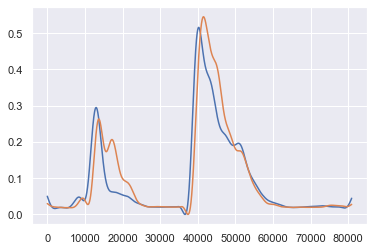

In [89]:
plt.plot(envelope_info_list_spiromask[1][::2])
plt.plot(envelope_info_list_spiromask[2][::2])
         

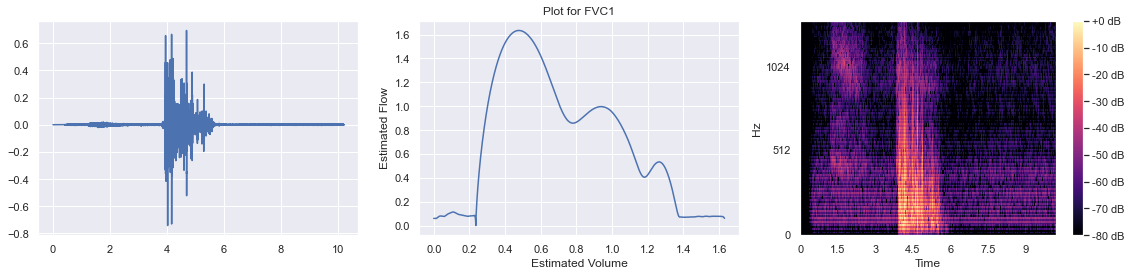

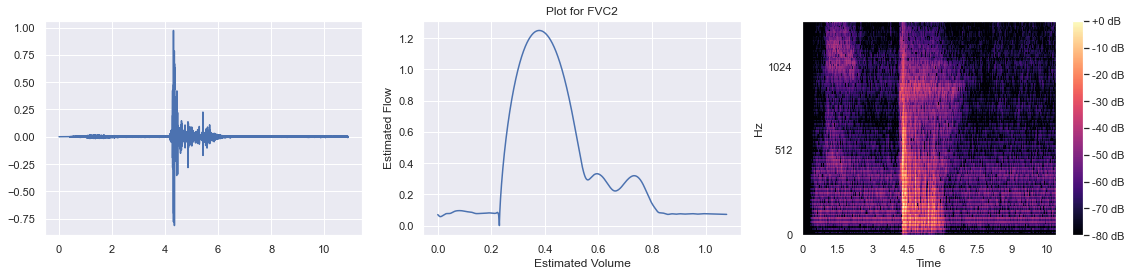

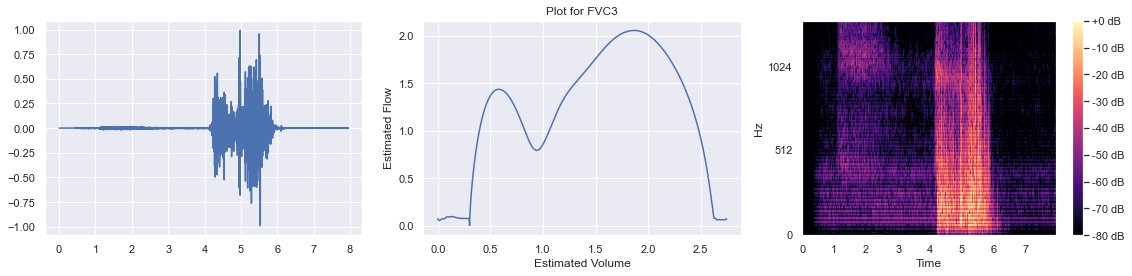

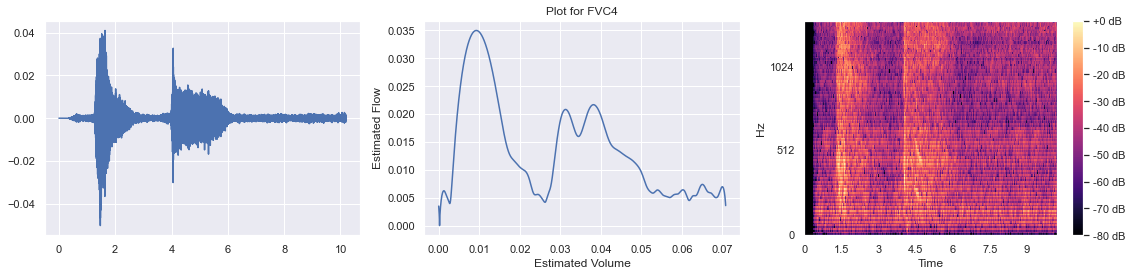

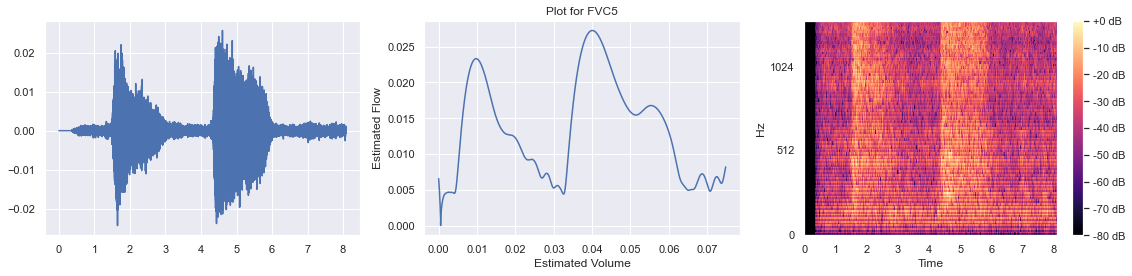

In [11]:
#phone data
    
mypath="phonedata/"
(_, _, filenames) = next(os.walk(mypath))
names = [file.split('.')[0] for file in filenames]


#arrray to store the HT envelope
envelope_info_list = []


for file in filenames:
    fig,ax = plt.subplots(1,3,figsize=(16,4))
    x, fs = librosa.load(mypath+file, sr=44100)
    t = np.arange(0,len(x))/fs
    cutoff_low = 50 # desired cutoff frequency of the filter, Hz
    cutoff_high = 1500
    order = 4

    #x_filt = butter_highpass_filter(x, cutoff, fs, order)
    x_filt = butter_bandpass_filter(x,cutoff_low,cutoff_high,fs,order)
    x_filt_hilbert = signal.hilbert(x_filt)
    envelope_hat = np.abs(x_filt_hilbert)
    #filter the Hilbert envelope
    nyq_rate = fs /0.5
    width = 1.0/nyq_rate # 5 Hz filter transition width.
    ripple_db = 10.0 # stop band attenuation
    fL_hz = 10
    N, beta = signal.kaiserord(ripple_db, width)
    taps = signal.firwin(N, fL_hz/nyq_rate, window=('kaiser', beta))
    envelope_hat_filt = signal.filtfilt(taps, 1,envelope_hat)
    t = np.arange(0,len(envelope_hat_filt))/fs

    #at this point we have the 
    #scale the envelope is estimate of flow rate. We will scale this to match actual flow range
    envelope_hat_filt = np.interp(envelope_hat_filt, (envelope_hat_filt.min(), 1), (0, 8))
    rPEF = round(envelope_hat_filt.max(),2)

    estdVolume = np.cumsum(envelope_hat_filt)
    estdVolume = np.interp(estdVolume, (0, np.cumsum([1]*len(t)).max()), (0, 8))
    #FEV1 Estimate
    rFEV1 = round(estdVolume[np.where(t==1)[0][0]],2)
    #FVC Estimate
    rFVC = round(estdVolume[-1],2)

    rRatio = (rFEV1/rFVC)*100
    ax[0].plot(t,x)
    

    ax[1].plot(estdVolume, envelope_hat_filt)
    ax[1].set_xlabel('Estimated Volume')
    ax[1].set_ylabel('Estimated Flow')
    ax[1].set_title('Plot for {}'.format(file.split('.')[0]))
    
    envelope_info_list.append(envelope_hat_filt)


    S = librosa.feature.melspectrogram(y=x, sr=fs, n_mels=128,fmax=cutoff_high)
    S_dB = librosa.power_to_db(S, ref=np.max)
    img = librosa.display.specshow(S_dB, x_axis='time',y_axis='mel', sr=fs,fmax=cutoff_high, ax=ax[2])
    fig.colorbar(img, ax=ax[2], format='%+2.0f dB')
    
    
    fig.tight_layout()
    
    plt.show()
    #break


In [16]:
envelope_info_list = np.array(envelope_info_list)

In [87]:
#measure dtw distance
skipT1 = 6
skipT2 = 6
distance, path = fastdtw(envelope_info_list[0][::skipT1], envelope_info_list[1][::skipT2], dist=euclidean)
print("Length of first time series is {} and the second is {}".format(len(envelope_info_list[0][::skipT1]),len(envelope_info_list[1][::skipT2])))
print("Distance = {}".format(distance))
#result_matrix = dtw(envelope_info_list[0][::20],envelope_info_list[1][::20])

Length of first time series is 75094 and the second is 80043
Distance = 1024.0144901012475


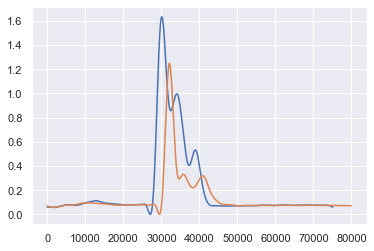

In [88]:
plt.plot(envelope_info_list[0][::skipT1])
plt.plot(envelope_info_list[1][::skipT1])

In [74]:
len(envelope_info_list[1][::20])

24013